<a href="https://colab.research.google.com/github/Sizwe100/Python-Random-Forest/blob/main/Khandisa_Climate_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
from google.colab import auth
from shapely.geometry import mapping
from datetime import datetime

# Authenticate and Initialize Earth Engine
auth.authenticate_user()
# Replace 'your-project-id' with your actual Google Cloud Project ID
ee.Initialize(project='ee-sizwepmthimkhulu') # Modified line to include the project parameter

# Load Khandisa shapefile from Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

shapefile_path = '/content/drive/My Drive/Khandisa/Khandisa_croped/Khandisa_crop.shp'
khandisa_gdf = gpd.read_file(shapefile_path)
khandisa_geom = mapping(khandisa_gdf.unary_union)
khandisa_roi = ee.Geometry(khandisa_geom)

# Function to compute NDVI, MSAVI, SAVI
def add_vegetation_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    msavi = image.expression(
        '((2 * NIR + 1) - sqrt((2 * NIR + 1) ** 2 - 8 * (NIR - RED))) / 2',
        {'NIR': image.select('B8'), 'RED': image.select('B4')}
    ).rename('MSAVI')
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + 0.5)) * 1.5',
        {'NIR': image.select('B8'), 'RED': image.select('B4')}
    ).rename('SAVI')
    return image.addBands([ndvi, msavi, savi])

# Sentinel-2 Collection
sentinel2 = (ee.ImageCollection('COPERNICUS/S2')
             .filterBounds(khandisa_roi)
             .filterDate('2019-01-01', '2024-10-31')
             .map(add_vegetation_indices)
             .select(['NDVI', 'MSAVI', 'SAVI']))

# Climate Data: Temperature and Precipitation
temp_collection = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')
precip_collection = ee.ImageCollection('NASA/GPM_L3/IMERG_MONTHLY_V06')

temperature = temp_collection.filterBounds(khandisa_roi).select('temperature_2m')
precipitation = precip_collection.filterBounds(khandisa_roi).select('precipitation')

# SPI and SPEI Calculation (Placeholder - Requires External Processing)
def compute_spi_spei(precip_series, timescale=3):
    rolling_sum = precip_series.rolling(timescale).sum()
    spi = (rolling_sum - rolling_sum.mean()) / rolling_sum.std()
    spei = spi  # Replace with PET calculation if needed
    return spi, spei

# Export Data to Drive
def export_to_drive(image_collection, description, folder):
    image = image_collection.mean()
    task = ee.batch.Export.image.toDrive(
        image=image.clip(khandisa_roi),
        description=description,
        folder=folder,
        fileNamePrefix=description,
        scale=30,
        region=khandisa_roi,
        maxPixels=1e13
    )
    task.start()
export_to_drive(sentinel2, 'Khandisa_Vegetation_Indices', 'Khandisa_Results')
export_to_drive(temperature, 'Khandisa_Temperature', 'Khandisa_Results')
export_to_drive(precipitation, 'Khandisa_Precipitation', 'Khandisa_Results')

Mounted at /content/drive


<ipython-input-6-fce09fc88916>:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  khandisa_geom = mapping(khandisa_gdf.unary_union)
/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


In [7]:
import os
folder_path = "/content/drive/My Drive/Khandisa_Results/"
print(os.listdir(folder_path))  # This should list all CSV files

['Khandisa_Precipitation.tif', 'Khandisa_Temperature (3).tif', 'NDVI_time_series_data.geojson', 'NDVI_time_series.csv', 'MSAVI_time_series.csv', 'SAVI_time_series.csv', 'precipitation_time_series.csv', 'Evap_tavg_time_series.csv', 'Khandisa_Temperature (2).tif', 'Combined_Climate_Vegetation.csv', 'Monthly_Climate_Vegetation_Indexes.csv', 'Cleaned_Monthly_Climate_Vegetation_Indexes.csv', 'Monthly_Climate_Vegetation_Indexes_A4.png', 'Enhanced_Monthly_Climate_Vegetation_Indexes_A4.png', 'Untitled document.gdoc', 'Khandisa_Temperature (1).tif', 'NDVI_Plots', 'Khandisa_Temperature.tif']


In [8]:
!ls "/content/drive/My Drive/Khandisa_Results/"

 Cleaned_Monthly_Climate_Vegetation_Indexes.csv       Monthly_Climate_Vegetation_Indexes_A4.png
 Combined_Climate_Vegetation.csv		      Monthly_Climate_Vegetation_Indexes.csv
 Enhanced_Monthly_Climate_Vegetation_Indexes_A4.png   MSAVI_time_series.csv
 Evap_tavg_time_series.csv			      NDVI_Plots
 Khandisa_Precipitation.tif			      NDVI_time_series.csv
'Khandisa_Temperature (1).tif'			      NDVI_time_series_data.geojson
'Khandisa_Temperature (2).tif'			      precipitation_time_series.csv
'Khandisa_Temperature (3).tif'			      SAVI_time_series.csv
 Khandisa_Temperature.tif			     'Untitled document.gdoc'


NameError: name 'monthly_df' is not defined

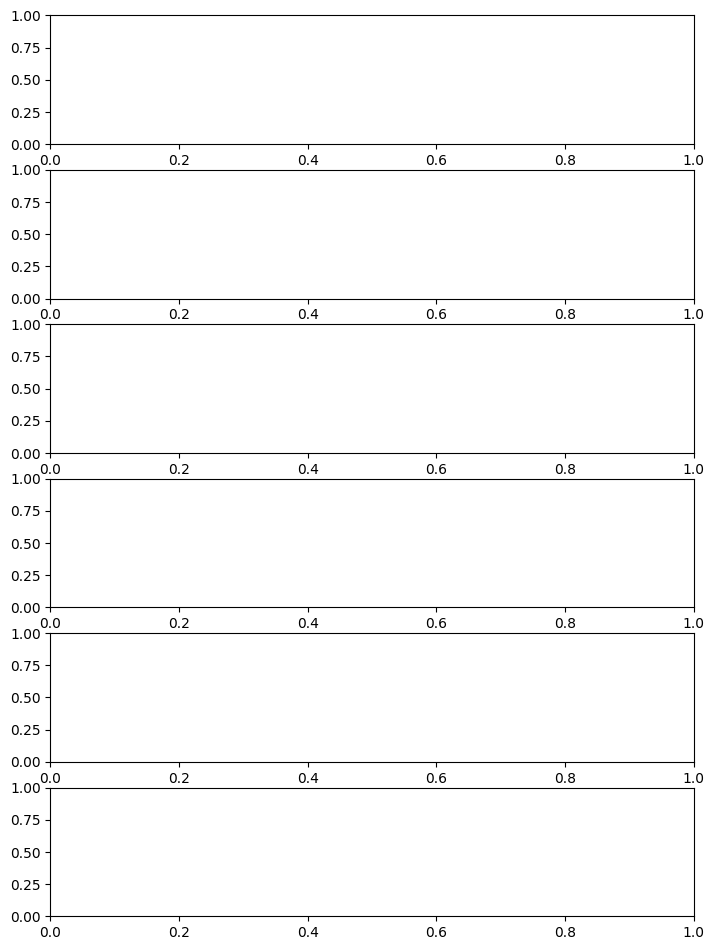

In [19]:
import matplotlib.pyplot as plt

# Set up the figure for multiple subplots (6 indexes, 1 column)
fig, axes = plt.subplots(6, 1, figsize=(8.3, 11.7))  # A4 size in inches (8.3x11.7)

# Plot each index in its own subplot
axes[0].plot(monthly_df.index, monthly_df['NDVI'], color='green', label='NDVI')
axes[0].set_title('NDVI')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('NDVI')
axes[0].legend()

axes[1].plot(monthly_df.index, monthly_df['MSAVI'], color='blue', label='MSAVI')
axes[1].set_title('MSAVI')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('MSAVI')
axes[1].legend()

axes[2].plot(monthly_df.index, monthly_df['SAVI'], color='red', label='SAVI')
axes[2].set_title('SAVI')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('SAVI')
axes[2].legend()

axes[3].plot(monthly_df.index, monthly_df['Precipitation'], color='cyan', label='Precipitation')
axes[3].set_title('Precipitation')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Precipitation (mm)')
axes[3].legend()

axes[4].plot(monthly_df.index, monthly_df['ETo'], color='magenta', label='ETo')
axes[4].set_title('ETo (Evapotranspiration)')
axes[4].set_xlabel('Date')
axes[4].set_ylabel('ETo')
axes[4].legend()

axes[5].plot(monthly_df.index, monthly_df['VCI'], color='orange', label='VCI')
axes[5].set_title('VCI')
axes[5].set_xlabel('Date')
axes[5].set_ylabel('VCI')
axes[5].legend()

# Adjust layout to fit all subplots
plt.tight_layout()

# Save the figure to Google Drive as a PNG file
output_image_path = folder_path + "Monthly_Climate_Vegetation_Indexes_A4.png"
plt.savefig(output_image_path)

# Show the plot
plt.show()

print(f"✅ Plot saved to: {output_image_path}")

NameError: name 'monthly_df' is not defined

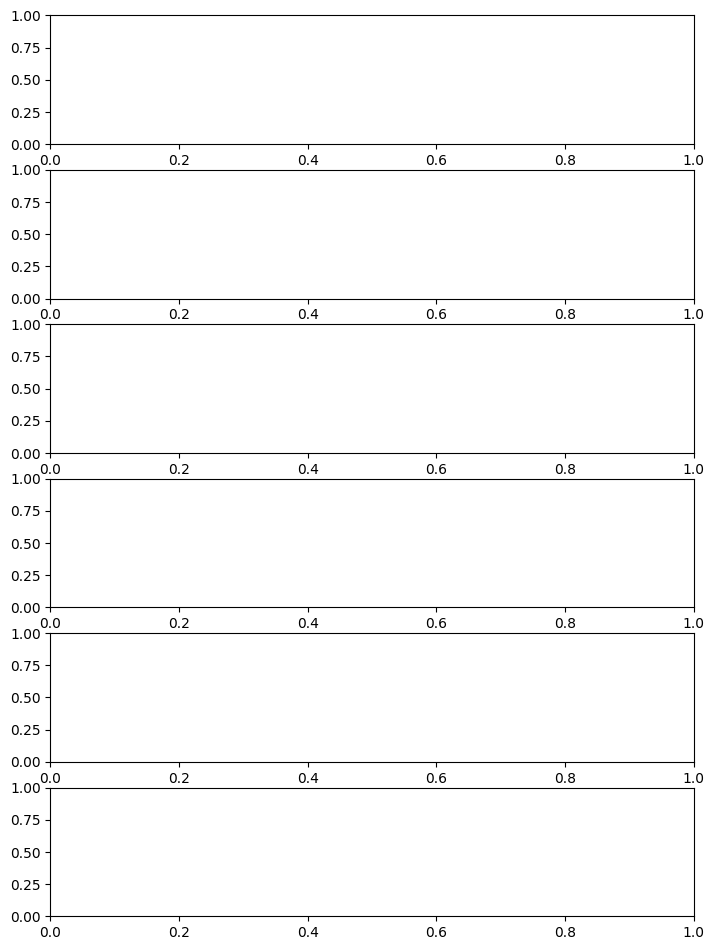

In [21]:
import numpy as np

# Define a function to highlight anomalies based on a threshold
def highlight_anomalies(data, threshold=1.5):
    mean = data.mean()
    std_dev = data.std()
    upper_bound = mean + threshold * std_dev
    lower_bound = mean - threshold * std_dev
    anomalies = (data > upper_bound) | (data < lower_bound)
    return anomalies

# Set up the figure for multiple subplots (6 indexes, 1 column)
fig, axes = plt.subplots(6, 1, figsize=(8.3, 11.7))  # A4 size in inches (8.3x11.7)

# Plot each index in its own subplot with enhancements
for i, index in enumerate(['NDVI', 'MSAVI', 'SAVI', 'Precipitation', 'ETo', 'VCI']):
    ax = axes[i]

    # Get the data series for each index
    data = monthly_df[index]

    # Highlight anomalies
    anomalies = highlight_anomalies(data)
    ax.plot(monthly_df.index, data, color='blue', label=index, linewidth=1.5)  # Plot line
    ax.scatter(monthly_df.index[anomalies], data[anomalies], color='red', zorder=5, label="Anomalies", marker='x')  # Highlight anomalies

    # Add title and labels
    ax.set_title(f'{index} - Monthly Trend', fontsize=12)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel(f'{index} Value', fontsize=10)

    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.7)

    # Show month labels on x-axis
    ax.set_xticks(monthly_df.index[::3])  # Show every third month for clarity
    ax.set_xticklabels(monthly_df.index.strftime('%b-%Y')[::3], rotation=45)

    # Add legend
    ax.legend(loc='upper left')

# Adjust layout to fit all subplots
plt.tight_layout()

# Save the figure to Google Drive as a PNG file
output_image_path = folder_path + "Enhanced_Monthly_Climate_Vegetation_Indexes_A4.png"
plt.savefig(output_image_path)

# Show the plot
plt.show()

print(f"✅ Enhanced plot saved to: {output_image_path}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load time series data
df = pd.read_csv("time_series.csv", parse_dates=["date"], index_col="date")

# Decompose using an additive model
decomposition = seasonal_decompose(df['value'], model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()
